# Kapitel 4 — Entscheidungsbäume zur **Regression** (winequality-red)

**Einleitung:** Im Gegensatz zu **Klassifikationsbäume**, die verwendet werden, um eine Zielvariable zu kategorisieren, werden **Regressionsbäume** verwendet werden, um eine **numerische Zielvariable **vorherzusagen**.

**Ziel:** Regressionsbaum mit `scikit-learn` für die Vorhersage der Weinqualität
trainieren, evaluieren (MSE, RMSE, $R^2$), visualisieren und durch
Hyperparametertuning verbessern

**Inhalt:**
1. Daten laden und vorbereiten
2. Basismodell: `DecisionTreeRegressor`
3. Evaluierung: MSE, RMSE, $R^2$ und Fehleranalyse
4. Baumvisualisierung
5. Grid Search: `max_depth`, `min_samples_leaf`, `min_samples_split`

In [1]:
# Umgebungs-Setup
import sys, os, math, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt

# Reproduzierbarkeit
np.random.seed(42)

# Versionsinfo (nützlich für Reproduktion)
print({
    "python": sys.version.split()[0],
    "numpy": np.__version__,
    "pandas": pd.__version__,
})

{'python': '3.10.12', 'numpy': '2.1.3', 'pandas': '2.2.3'}


## 1. Daten laden und vorbereiten

Aus dem UCI Machine Learning Repository wird der Datensatz **`winequailty-red`** für die Verprobung von Weinen verwendet. Der winequality-red Datenset ist Teil des UCI Machine Learning Repositories und
enthält chemische Analyse von Weinen sowie die Qualitätseinschätzungen von Experten. Der Datensatz enthält 1599 Einträge und 12 Merkmale:

- `fixed acidity`
- `volatile acidity`
- `citric acid`
- `residual sugar`
- `chlorides`
- `free sulfur dioxide`
- `total sulfur dioxide`
- `density`
- `pH`
- `sulphates`
- `alcohol`

**Zielvariable:** `quality` (ganzzahlig 0–10) -> Qualität des Weins, die auf einer Skala von 0 bis 10 bewertet wird

Legen Sie die CSV lokal ab und tragen den Pfad unten ein. Erwartete Spalten (Features):

In [2]:
# Passen Sie den Pfad an, falls nötig
DATA_PATH = "../data/processed/winequality-red.csv"  # z.B. ".../winequality-red.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Datei nicht gefunden: {DATA_PATH}\n"
        "Laden Sie 'winequality-red.csv' vom UCI Repository herunter und "
        "speichern Sie sie am angegebenen Ort."
    )

# Laden
df = pd.read_csv(DATA_PATH, sep=";")

# Schneller Datencheck (knapp gehalten)
print(df.shape)
print(df.isnull().sum().to_string())
df.head(3)

(1599, 12)
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


### Train/Test-Split
Wir trennen Features (`X`) und Ziel (`y`) und splitten 80/20.

In [3]:
# Feature-/Ziel-Definition
X = df.drop(columns=["quality"])
y = df["quality"]

# Train/Test
X_tr, X_tst, y_tr, y_tst = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_tr.shape, X_tst.shape

((1279, 11), (320, 11))

## 2. Basismodell: `DecisionTreeRegressor`
Wir starten mit Defaults und prüfen Baumtiefe und Blattanzahl.

In [4]:
# Hinweis zu 'criterion':
# Neuere scikit-learn Versionen nutzen 'squared_error' (früher 'mse').
reg = DecisionTreeRegressor(random_state=42)

reg.fit(X_tr, y_tr)

print("Tiefe:", reg.get_depth())
print("Blätter:", reg.get_n_leaves())

Tiefe: 25
Blätter: 335


## 3. Evaluierung: MSE, RMSE, $R^2$ und MAE

Es gibt verschiedene Kriterien, die zur Messung der Qualität eines Splits verwendet werden können, z. B. der mittlere quadratische Fehler (**_MSE_** -- Mean Squared Error), der mittlere absolute Fehler (**_MAE_** -- Mean Absolute Error) usw.

Standardmäßig verwendet `DecisionTreeRegressor` das **_MSE_**-Kriterium (**squared\_error**) für den Split, und keine Begrenzung für die Anzahl der Blattknoten oder die Tiefe des Baums. Das ist auch das am häufigsten verwendete Kriterium für Regressionsbäume allgemein. Dieser ist als Summe der quadratischen Unterschiede zwischen den vorhergesagten und den tatsächlichen Werten für jede Stichprobe in einer Teilmenge definiert:

$
MSE=\frac{1}{n}\sum_{i=1}^n\left(y_i - \widehat{y}_i \right)\;,
$

wobei $n$ die Anyahl der Stichproben in der Teilmenge ist, $y_i$ der tatsächliche Zielwert für die $i$-te Stichprobe ist, und $\widehat{y}_i$ der vorhergesagte Zielwert für $i$-te Stichprobe ist.

**Knoten-Impurität (Split-Kriterium) für einen Knoten $S$:**

$$
\mathrm{MSE}(S)
= \frac{1}{\lvert S\rvert}\sum_{i\in S}\bigl(y_i-\bar y_S\bigr)^2,
\qquad
\bar y_S=\frac{1}{\lvert S\rvert}\sum_{i\in S} y_i
$$

**Impurity-Decrease eines Splits $S\to (S\_L,S\_R)\:**

$$
\Delta
= \mathrm{MSE}(S)
- \frac{\lvert S_L\rvert}{\lvert S\rvert}\,\mathrm{MSE}(S_L)
- \frac{\lvert S_R\rvert}{\lvert S\rvert}\,\mathrm{MSE}(S_R)
$$

**Testmetriken:**

$$
\mathrm{MSE}_{\text{test}}
= \frac{1}{n}\sum_{i=1}^{n}\bigl(y_i-\hat y_i\bigr)^2,
\qquad
\mathrm{RMSE}=\sqrt{\mathrm{MSE}_{\text{test}}}
$$

$$
\mathrm{MAE}
= \frac{1}{n}\sum_{i=1}^{n}\lvert y_i-\hat y_i\rvert,
\qquad
R^2
= 1-\frac{\sum_{i=1}^{n}\bigl(y_i-\hat y_i\bigr)^2}
{\sum_{i=1}^{n}\bigl(y_i-\bar y\bigr)^2},
\quad
\bar y=\frac{1}{n}\sum_{i=1}^{n}y_i
$$



Wir berechnen **MSE**, **RMSE**, **MAE** und **$R^2$** auf dem Testset.

In [5]:
y_hat = reg.predict(X_tst)

mse = mean_squared_error(y_tst, y_hat)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_tst, y_hat)
r2 = r2_score(y_tst, y_hat)

print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R^2  : {r2:.4f}")

MSE  : 0.6062
RMSE : 0.7786
MAE  : 0.4625
R^2  : 0.0723


## MSE-basiertes Splitten: Kernidee

- Daten am aktuellen Knoten $S$ nach **Merkmal** $x_j$ und **Schwelle** $v$ in zwei Teilmengen aufteilen  
  $S_L=\{\,i\in S: x_{ij}<v\,\}$, $S_R=\{\,i\in S: x_{ij}\ge v\,\}$
- Für jede Teilmenge den **MSE** berechnen
- Feature–Schwellenwert-Paar wählen, das den **gewichteten Kind-MSE** minimiert

### Bewertung eines Splits
- **Teilmengen-MSE**  

$$
\mathrm{MSE}(S)=\frac{1}{\lvert S\rvert}\sum_{i\in S}\bigl(y_i-\bar y_S\bigr)^2,
\qquad
\bar y_S=\frac{1}{\lvert S\rvert}\sum_{i\in S} y_i
$$

- **Split-Score (zu minimieren)**  

$$
\text{Score}(x_j,v)
=\frac{\lvert S_L\rvert}{\lvert S\rvert}\,\mathrm{MSE}(S_L)
+\frac{\lvert S_R\rvert}{\lvert S\rvert}\,\mathrm{MSE}(S_R)
$$

- Bester Split: $(x_j^{*}, v^{*})=\arg\min_{j,v}\ \text{Score}(x_j, v)$

### Beispielhafte Partition
- Gegeben Merkmal $x$ und Schwelle $v$:  
  Linkes Kind $S_L=\{\,x<v\,\}$, Rechtes Kind $S_R=\{\,x\ge v\,\}$
- Berechne $\mathrm{MSE}(S_L)$ und $\mathrm{MSE}(S_R)$, bilde gewichteten Mittelwert, wähle minimales Paar

### Hinweis zu Ausreißern
- **MSE ist ausreißerempfindlich**: Große Fehler $(|y_i-\hat y_i|)$ werden **quadratisch** gewichtet  
- Konsequenz: Baum kann Ausreißer **überanpassen** (tiefe/kleine Blätter)  
- Praxis: Hyperparameter wie `max_depth`, `min_samples_leaf`, `min_samples_split` zur **Regularisierung** setzen

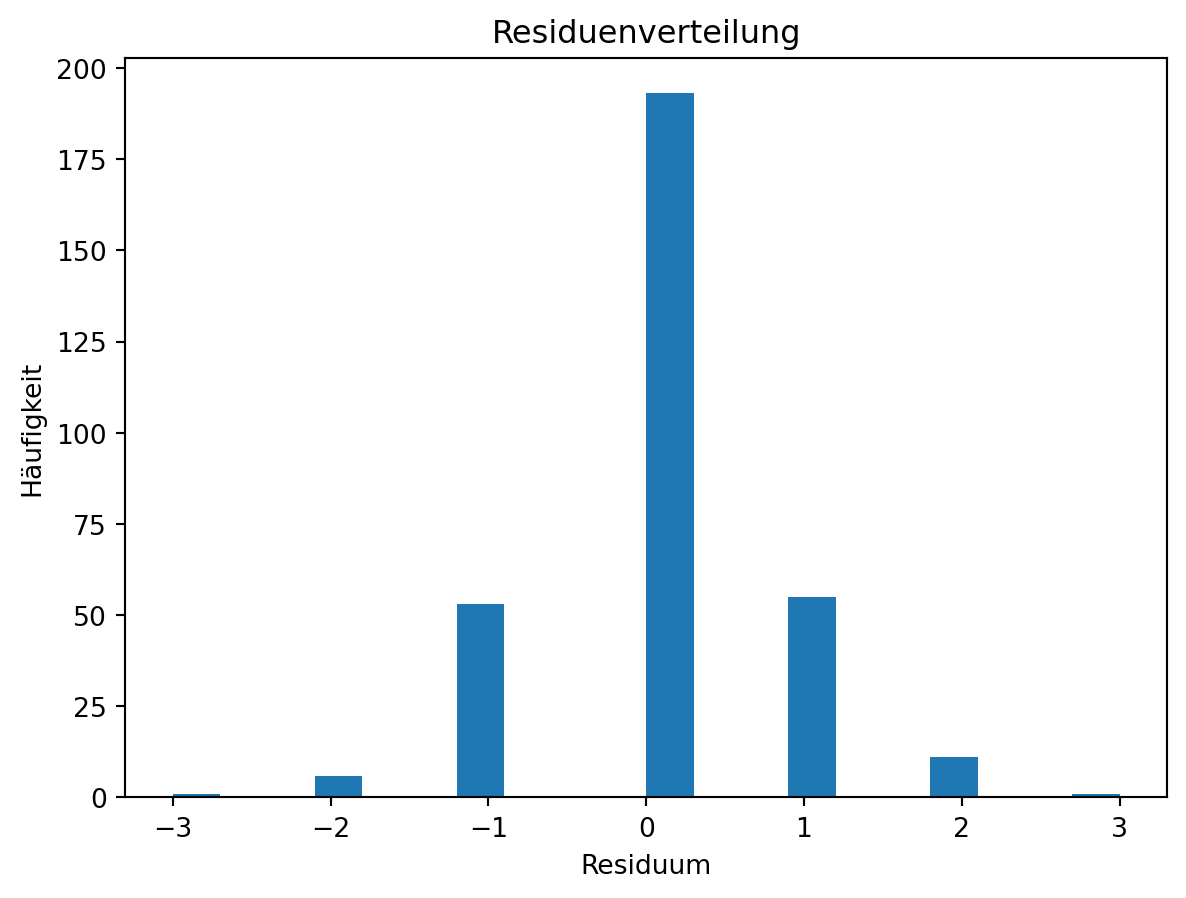

In [6]:
# Residuen
res = y_tst - y_hat
plt.figure()
plt.hist(res, bins=20)
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.title("Residuenverteilung")
plt.show()

## 4. Baumvisualisierung

Wir zeichnen den trainierten Regressionsbaum. Zusätzlich geben wir eine
kompakte Textdarstellung aus.

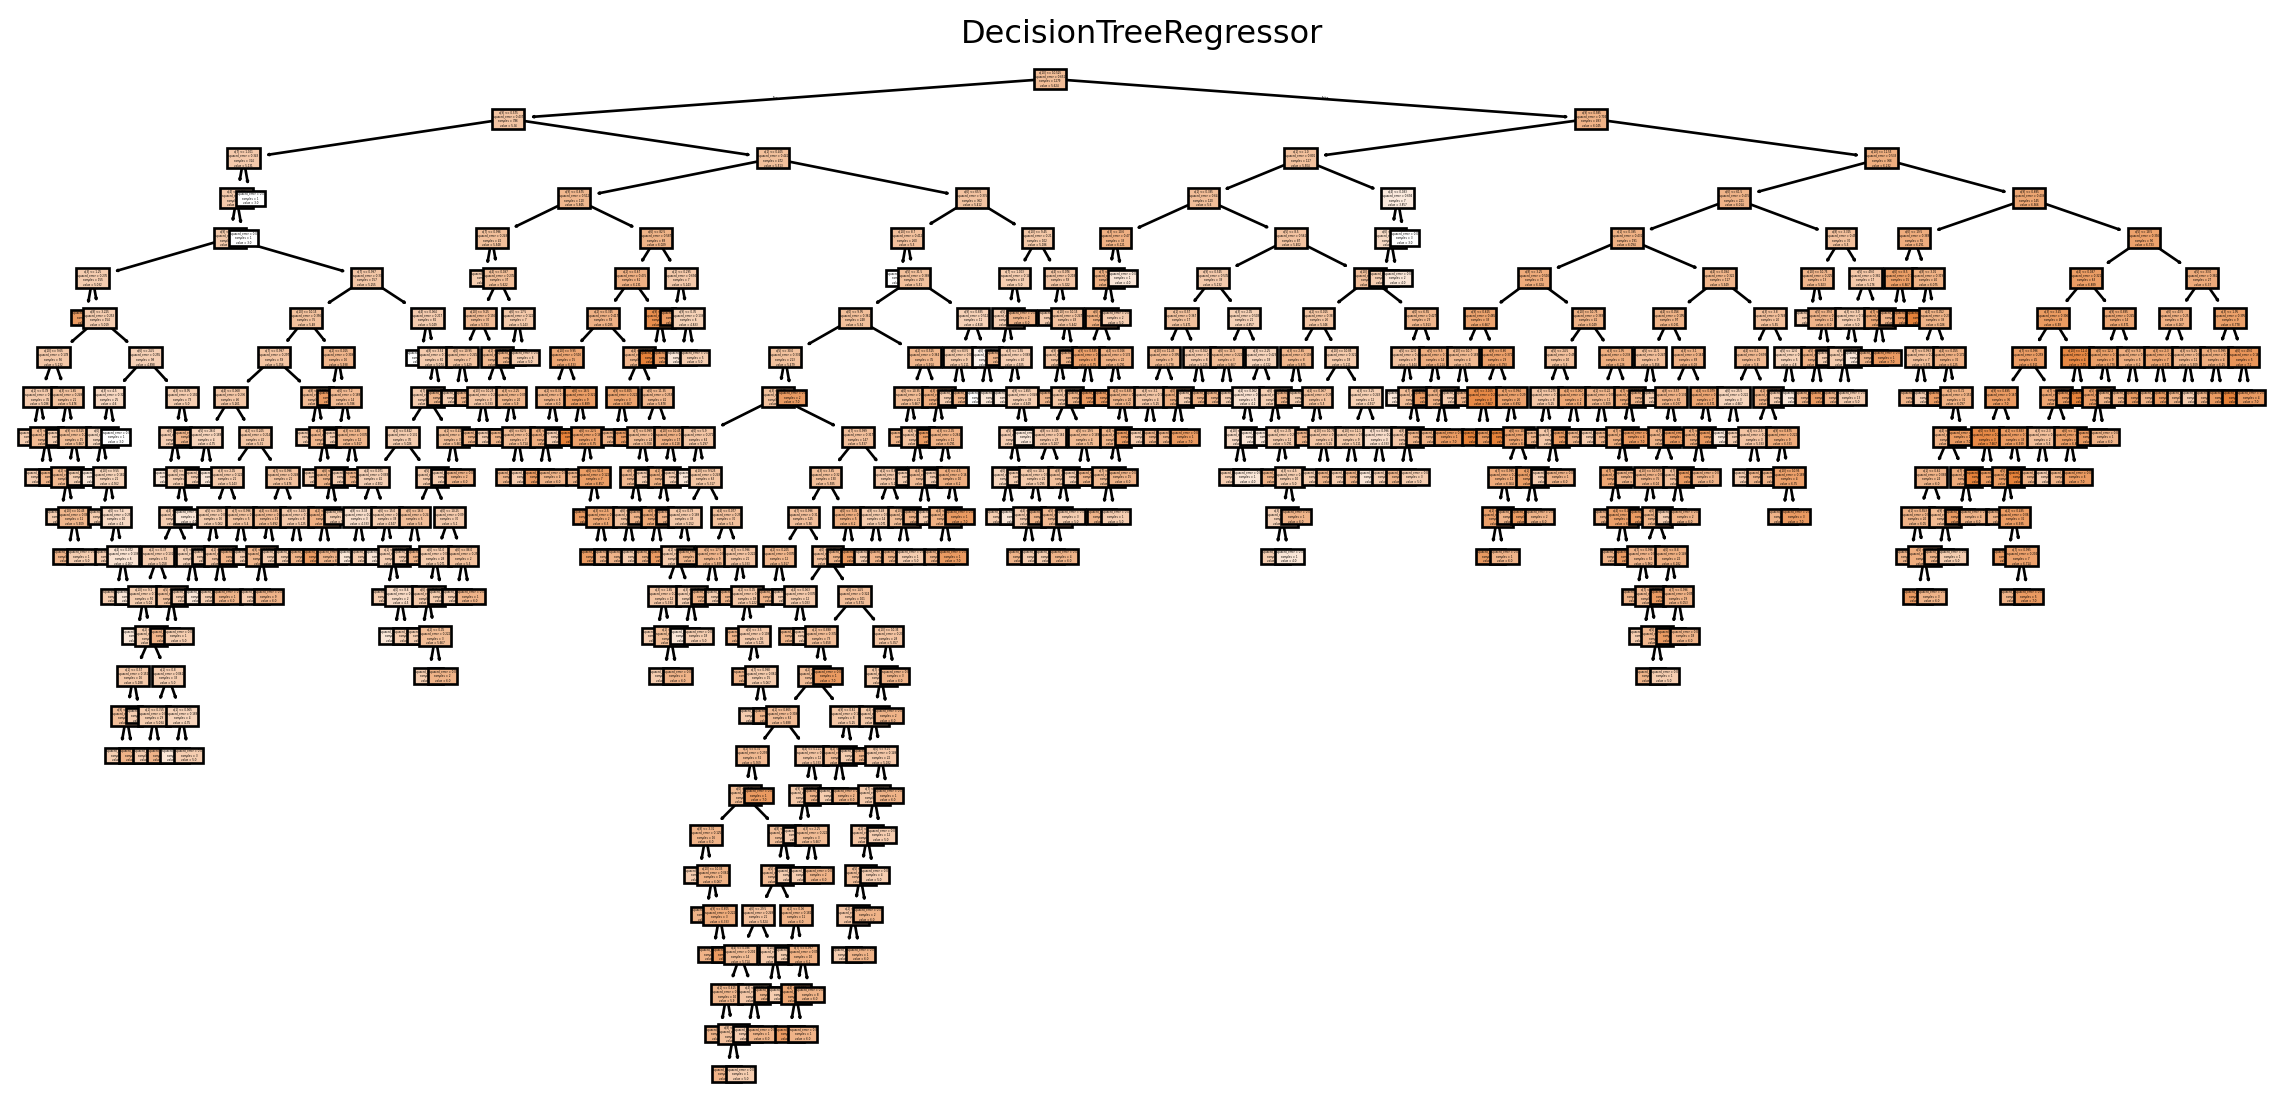

In [7]:
plt.figure(figsize=(15,7))
plot_tree(reg, filled=True)
plt.title("DecisionTreeRegressor")
plt.show()

In [8]:
# Textdarstellung (gekürzt über max_depth)
print(export_text(reg, feature_names=list(X.columns), max_depth=3))

|--- alcohol <= 10.53
|   |--- sulphates <= 0.57
|   |   |--- density <= 1.00
|   |   |   |--- chlorides <= 0.25
|   |   |   |   |--- truncated branch of depth 14
|   |   |   |--- chlorides >  0.25
|   |   |   |   |--- value: [3.00]
|   |   |--- density >  1.00
|   |   |   |--- value: [3.00]
|   |--- sulphates >  0.57
|   |   |--- volatile acidity <= 0.41
|   |   |   |--- sulphates <= 0.68
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- sulphates >  0.68
|   |   |   |   |--- truncated branch of depth 9
|   |   |--- volatile acidity >  0.41
|   |   |   |--- total sulfur dioxide <= 65.50
|   |   |   |   |--- truncated branch of depth 22
|   |   |   |--- total sulfur dioxide >  65.50
|   |   |   |   |--- truncated branch of depth 9
|--- alcohol >  10.53
|   |--- sulphates <= 0.58
|   |   |--- volatile acidity <= 1.00
|   |   |   |--- volatile acidity <= 0.38
|   |   |   |   |--- truncated branch of depth 8
|   |   |   |--- volatile acidity >  0.38
|   |   |   |   |--- tr

## 5. Hyperparameter: Grid Search

Wir optimieren `max_depth`, `min_samples_leaf` und `min_samples_split`
per 5-fach-CV. Zielmetrik: **negativer MSE** (entspricht MSE-Minimierung).

In [9]:
param_grid = {
    "max_depth": [None, 3, 5, 7, 10],
    "min_samples_leaf": [1, 3, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
}

gcv = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=None,
)

gcv.fit(X_tr, y_tr)

print("Beste Parameter:", gcv.best_params_)
print("CV-Score (neg MSE):", f"{gcv.best_score_:.4f}")

best_reg = gcv.best_estimator_
y_hat_best = best_reg.predict(X_tst)

mse_b = mean_squared_error(y_tst, y_hat_best)
rmse_b = math.sqrt(mse_b)
mae_b = mean_absolute_error(y_tst, y_hat_best)
r2_b = r2_score(y_tst, y_hat_best)

print("\nTestleistung (bestes Modell)")
print(f"MSE  : {mse_b:.4f}")
print(f"RMSE : {rmse_b:.4f}")
print(f"MAE  : {mae_b:.4f}")
print(f"R^2  : {r2_b:.4f}")

Beste Parameter: {'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 2}
CV-Score (neg MSE): -0.4539

Testleistung (bestes Modell)
MSE  : 0.4382
RMSE : 0.6620
MAE  : 0.5200
R^2  : 0.3295


### Hinweis
- Ergebnisse variieren je nach CSV-Version, Preprocessing und Zufallssplit
- Für reproduzierbare Splits `random_state` konstant halten